In [1]:
!nvidia-smi

Sun Sep  8 10:11:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

!pip install -U datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [1]:
%%capture
!pip install transformers==4.19.2

In [2]:

!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=03f52634e3c4d72038ac8ca650532134de7c085ac2930ef3972b48e3598950ad
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [3]:
from datasets import load_metric
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/articleset.csv")
df.head()

,title,summary,content
0,Mental Note Vol. 24,Photo credit: Leo Leung<|n|><|n|>People want t...,Photo by Josh Riemer on Unsplash<|n|><|n|>Merr...
1,Your Brain On Coronavirus,Photo credit: Leo Leung<|n|><|n|>People want t...,Your Brain On Coronavirus<|n|><|n|>A guide to ...
2,Mind Your Nose,Photo credit: Leo Leung<|n|><|n|>People want t...,Mind Your Nose<|n|><|n|>How smell training can...
3,The 4 Purposes of Dreams,Photo credit: Leo Leung<|n|><|n|>People want t...,Passionate about the synergy between science a...
4,Surviving a Rod Through the Head,Photo credit: Leo Leung<|n|><|n|>People want t...,"You’ve heard of him, haven’t you? Phineas Gage..."


In [4]:
print(df.shape)
df = df.dropna()
print(df.shape)

(1035, 3)
(1035, 3)


In [5]:
df['length'] = df.content.map(lambda x:len(x.split(" ")))

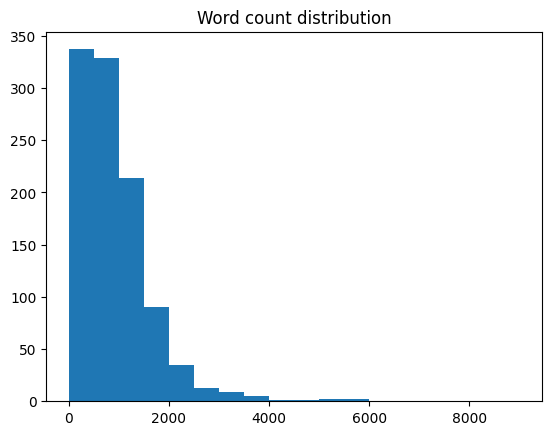

In [8]:
numofwords = df.length
from matplotlib import pyplot as plt
fig=plt.figure()
plt.hist(numofwords.to_numpy(),bins=[0,500,1000,1500,2000,2500,3000,3500,4000,5000,6000,7000,8000,9000])
plt.title("Word count distribution")
plt.show()

In [11]:
tempdf = df[df.length<=800]
tempdf = tempdf[tempdf.length>=100]
tempdf.shape

(530, 4)

In [12]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")


Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [33]:
max_i_len = 1024
max_o_len=1024
batch_s = 4
def process_data_inputs(batch):
  input = tokenizer(batch["content"],padding="max_length",truncation = True,max_length=max_i_len,)
  output = tokenizer(batch["content"],padding="max_length",truncation = True,max_length=max_o_len,)
  batch["input_ids"]= input.input_ids
  batch["attention_mask"]=input.attention_mask

  batch["global_attention_mask"]=len(batch["input_ids"])*[[0 for _ in range(len(batch["input_ids"][0]))]]
  batch["global_attention_mask"][0][0]=1
  batch["labels"]=output.input_ids
  batch["labels"]=[[-100 if token==tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]
  return batch



In [34]:
import numpy as np
train,validate,test = np.split(tempdf.sample(frac=1,random_state=42),[int(.4*len(df)),int(.5*len(df))])


In [35]:
print(train.shape,validate.shape)

(414, 4) (103, 4)


In [36]:
train = train[0:250]
validate = validate[25:50]
print(train.shape,validate.shape)

(250, 4) (25, 4)


In [37]:
from datasets import Dataset
traindataset = Dataset.from_pandas(train)
valdatset = Dataset.from_pandas(validate)

In [38]:
traindataset=traindataset.map(
    process_data_inputs,
    batched=True,
    batch_size = batch_s,
    remove_columns=["content","summary","length","__index_level_0__"],
)

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [39]:
valdatset = valdatset.map(
    process_data_inputs,
    batched = True,
    batch_size=batch_s,
    remove_columns = ["content","summary","length","__index_level_0__"],
)

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [40]:
traindataset.set_format(type = "torch",columns=["input_ids","attention_mask","global_attention_mask","labels"],)
valdatset.set_format(type = "torch",columns=["input_ids","attention_mask","global_attention_mask","labels"],)

In [47]:
from transformers import AutoModelForSeq2SeqLM,Seq2SeqTrainer,Seq2SeqTrainingArguments
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384",gradient_checkpointing=True,use_cache=False)
led.config.num_beams = 2
led.config.max_length = 1024
led.config.min_length = 512
led.config.length_penalty = 2.0
led.config.early_stopping=True
led.config.no_repeat_ngram_size=3
rouge = load_metric("rouge")
def compmetrics(pred):
  labels_ids = pred.label_ids
  pred_ids = pred.predictions
  pred_str = tokenizer.batch_decode(pred_ids,skip_special_tokens=True)
  labels_ids[labels_ids==-100]= tokenizer.pad_token_id
  label_str = tokenizer.batch_decode(labels_ids,skip_special_tokens=True)
  rouge_output = rouge.compute(
      predictions=pred_str,references=label_str,rouge_types=["rouge2"]
  )["rouge2"].mid
  return{
      "rouge2_precision":round(rouge_output.precision,4),
      "rouge2_recall":round(rouge_output.recall,4),
      "rouge2_fmeasure":round(rouge_output.fmeasure,4),

  }
training_args = Seq2SeqTrainingArguments(
    predict_with_generate = True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_s,
    per_device_eval_batch_size=batch_s,
    output_dir="./",
    logging_steps=5,
    eval_steps=10,
    save_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=4,
    num_train_epochs=2
)


loading configuration file https://huggingface.co/allenai/led-base-16384/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ec844bead6f5bbcd6ac727b57e595c2ba40b0970f91cb923423773f72fe1702f.898baac75d55d484b1b1de95b8ab791987c78591acf36ce6131b56d0d2d26af7
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing"

In [48]:
trainer= Seq2SeqTrainer(
    model = led,
    tokenizer= tokenizer,
    args=training_args,
    compute_metrics=compmetrics,
    train_dataset=traindataset,
    eval_dataset=valdatset,
)

In [49]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `LEDForConditionalGeneration.forward` and have been ignored: title. If title are not expected by `LEDForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 250
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 30
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will 

Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
10,0.285500,0.141343,0.815600,0.755600,0.757500
20,0.250800,0.120513,0.793900,0.785600,0.770900


The following columns in the evaluation set don't have a corresponding argument in `LEDForConditionalGeneration.forward` and have been ignored: title. If title are not expected by `LEDForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 25
  Batch size = 4
Saving model checkpoint to ./checkpoint-10
Configuration saved in ./checkpoint-10/config.json
Model weights saved in ./checkpoint-10/pytorch_model.bin
tokenizer config file saved in ./checkpoint-10/tokenizer_config.json
Special tokens file saved in ./checkpoint-10/special_tokens_map.json
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for m

Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
10,0.285500,0.141343,0.815600,0.755600,0.757500
20,0.250800,0.120513,0.793900,0.785600,0.770900


KeyboardInterrupt: 

In [50]:
sample=tempdf.sample(frac=0.005,random_state=12)
sample.shape

(3, 4)

In [51]:
sample= sample[['content','summary']]
sample['content']

,content
138,"As of the time of this writing, a new and more..."
313,Hedonic Well-Being<|n|><|n|>The hedonic aspect...
985,How we will get there.<|n|><|n|>Economic polic...


In [54]:
sample['summary'][138]

'Photo credit: Leo Leung<|n|><|n|>People want to know why you do what you do.<|n|><|n|>If you’re an entrepreneur, your investors, customers, and employees want to know why you founded your company.Apply for a job, and recruiters ask about your career path.If you’re a freelancer, everyone is curious about how you got started.<|n|><|n|>Why do we crave origin stories?Because they reveal character.Superman is a good guy because his planet exploded, his parents sent him to Earth, and the Kents raised him to fight evil.Steve Jobs became a trusted CEO, in part, by bouncing back from failure.My dad thrived as a home builder, but only after terminating a partnership with a prominent colleague whose practices he found unethical.<|n|><|n|>In other words:<|n|><|n|>Your origin story helps people decide whether or not to trust you.<|n|><|n|>How to Craft a Powerful Origin Story: The 5 Essential Elements<|n|><|n|>In strategic messaging and positioning engagements with CEOs, as well as business storyte

In [57]:
from datasets import Dataset
pubmed_test = Dataset.from_pandas(sample)
import torch
from datasets import load_dataset,load_metric
from transformers import LEDTokenizer,LEDForConditionalGeneration
tokenizer= LEDTokenizer.from_pretrained("/content/checkpoint-10")
model = LEDForConditionalGeneration.from_pretrained("/content/checkpoint-10").to("cuda").half()
def gen_ans(batch):
  input_dict = tokenizer(batch['summary'],padding="max_length",max_length=1024,return_tensors="pt",truncation=True)
  input_ids = input_dict.input_ids.to("cuda")
  attention_mask = input_dict.attention_mask.to("cuda")
  global_attention_mask = torch.zeros_like(attention_mask)
  predicted_abstract_ids = model.generate(input_ids,attention_mask=attention_mask,global_attention_mask=global_attention_mask)
  batch["predicted_content"]=tokenizer.batch_decode(predicted_abstract_ids,skip_special_tokens=True)
  return batch
result = pubmed_test.map(gen_ans,batched=True,batch_size=2)


Didn't find file /content/checkpoint-10/added_tokens.json. We won't load it.
loading file /content/checkpoint-10/vocab.json
loading file /content/checkpoint-10/merges.txt
loading file None
loading file /content/checkpoint-10/special_tokens_map.json
loading file /content/checkpoint-10/tokenizer_config.json
loading configuration file /content/checkpoint-10/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [58]:
result['content'][1]

'Hedonic Well-Being<|n|><|n|>The hedonic aspect of well-being has to do with positive affect and mood states. It’s about maximizing pleasure and enjoyment at the same time as minimizing pain and suffering.<|n|><|n|>Daniel Kahneman and other psychologists argue that this is one of the most important aspects of well-being. They argue that research and clinical treatments should focus on hedonism; they should amplify happiness, foster pleasurable experiences, and reduce negative emotions like sadness and dissatisfaction.<|n|><|n|>Digital games quite clearly contribute to these positive mood states — they’re fun. The interactive and rewarding features in games have been shown to result in pleasurable experiences.<|n|><|n|>Some studies have found that games help to reduce negative states like stress and sadness. They have been found to help people recover from workplace exhaustion and work-related stress — much more so than watching videos or TV.<|n|><|n|>They seem to do this by creating “e

In [63]:
result['predicted_content'][1]

'Photo credit: Leo Leung<|n|><|n |>People want to know why you do what you do.<|n/></n|>If you’re an entrepreneur, your investors, customers, and employees want to ask about why you founded your company.Apply for a job, and recruiters ask about your career path.If you don’t have a career path, everyone is curious about how you got started.<|N|>< |n|></>Why do we crave origin stories?Because they reveal character.Superman is a good guy because his planet exploded, his parents sent him to Earth, and the Kents raised him to fight evil.Steve Jobs became a trusted CEO, in part, by bouncing back from failure.My dad thrived as a home builder, but only after terminating a partnership with a prominent colleague whose practices he found unethical.<|nis|><-|n|>>In other words:<|N/><|nb|>Your origin story helps people decide whether or not to trust you.<|s|></nn|>How to Craft a Powerful Origin Story: The 5 Essential Elements<| n|><)|n|<In strategic messaging and positioning engagements with CEOs, 